#### WiSe 2021 Scientific Computing for Economists, Bonn University. Prof. Eisehhauer 
#### Student: Madina Japakhova, 3201064  

This project is an implementation of the core results of chapter *SEIR Models* in *Applied Mathematics for the Analysis of Biomedical data. Models,methods and MATLAB*. Specifically, I replicate the main results of a case study *HIV transmission and Seroconversion to AIDS*. Both the book and the project focus on mathematical modelling and parameter estimation. High school level of biology is assumed. I generally follow the chapter structure, but the focus of this notebook is to illustrate applications of alternative numerical methods in parameter estimation. 

The main book of reference (*Costa*) as well as other literuture used have been saved together with the data in the project submission folder.

This project should be viewed as a Jupyter notebook, otherwise some parts of the text do not display. The work was carried out and runs on Nuvolos (*Python 3.8*). If other applications are used for running this notebook, the most recent version of *matplotlib* library is recommended for the graphs to display.   

### SEIR Models    
    Susceptible - Exposed - Infectious - Removed/Recovered models    

In the light of the recent events, modelling the spread of infections diseases through a population has come to the front of research in statistics and mathematical epidemiology. SEIR models are widely used for this cause. The model describes a disease spread with a set of nonlinear differential equations, whose parameters are then to be estimated. The distinctive feature of SEIR models is that they can accomodate diseases with an incubation period, which corresponds to the *exposed* stage of the model. Incubation period is the time that takes place between being infected and having pronounced symptoms of the infection. It may range from a few hours to decades depending on the disease in question.

Before implementing the model, we need to define it.

### Introduction to the basics of SEIR models[<sup>1</sup>](#fn1)    

    This part introduces the main idea behind SEIR models. It is not directly related to the project and can be skipped. The essential part begins in section Practical applications of SEIR models.

For simplicity, assume we are given a population that happens to be a *closed system*, i.e. no new members are introduced or removed via birth/death or migration. Each member of the population at every time point belongs to one of these four groups:     

   **$S(t)$**: population susceptible to the infection    
   **$E(t)$**: population that was exposed to the infection. Infected, but symptomless.     
   **$I(t)$**: infectious population, i.e. people that are vectors of transmission *unless* measures are taken    
   **$R(t)$**: recovered or removed population, depending on context. In a closed system, people recover.

Members of the susceptible group **$S(t)$** become part of the exposed population $E(t)$ at a rate proportional to $a$<sub>1</sub>, part of the exposed population becomes infectious $I(t)$ at a rate proportional to $a$<sub>2</sub>, infected population recovers to $R(t)$ at a rate proportional to $a$<sub>3</sub>, people who recover return to the susceptibles at a rate proportional to $a$<sub>4</sub>. 

Below is the generic SEIR schema[<sup>2</sup>](#fn2):       


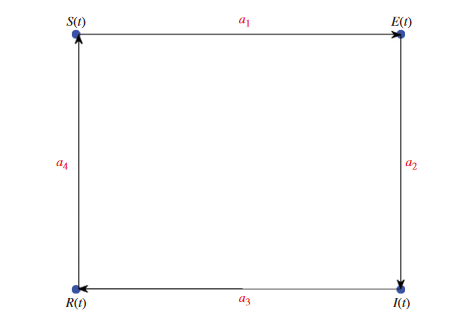

In [3]:
from IPython.display import Image
Image(filename='generic SEIR schema.png')  

Translating the qualitative and schematic description of the model into some math, we get a system of four differential equations that tell us how each of the four groups $-S(t)$, $E(t)$, $I(t)$, $R(t)-$ changes with time:  

$$ 
\frac{dS}{dt} = -a_{1}S(t) + a_{4}R(t)
$$

$$
\frac{dE}{dt}= a_{1}S(t) - a_{2}E(t)  
$$

$$
\frac{dI}{dt} = a_{2}E(t) + a_{3}I(t)   
$$

$$
\frac{dR}{dt} = a_{3}I(t) + a_{4}R(t)  
$$ 

To exercise the model, we need estimates of the parameters $a_{1}$, $a_{2}$, $a_{3}$, $a_{4}$ together with data on the *initial population* $S_{0} = S(t_{0})$, $E_{0}, I_{0}$. 

### Practical applications of SEIR models     
### Transmission of HIV and seroconversion to AIDS        

### Setting     

We are no longer in a closed system. New members are intoduced(removed) from the population via births(deaths) and migration.

$S(t)$: population susceptible to the transmission of HIV at time $t$     

$X(t)$: HIV positive ($HIV^{+}$) population    

$X_{q}$: quarantined $HIV^{+}$, they are no longer infectious at time $t$     

$Y(t)$: AIDS population     

$Y_{q}$: quarantined AIDS, they no longer infectious at time $t$    

$B$: number of new susceptibles introduced into the population per time unit   

$\mu_{D}$: rate at which people are removed from the population due to "non-AIDS" causes    

$\mu_{A}$: rate at which people die from AIDS    

$p$: proportion of the infectious population who are **not** "quarantined"    

$I(t) = X(t) + Y(t)$: total infectious population at time $t$   

$N(t( = S(t) + I(t)$: total active at risk population at time $t$     

$\lambda$$(t)$  $=$ $\beta$$(t)$$\frac{I(t)}{N(t)}$: the probability of HIV transmission per contact at time $t$    

$c(t)$: number of contacts(partners) at time $t$    

$v(t)$: seroconversion rate from HIV to AIDS; $\frac{1}{v(t)}$ $=$ incubation period   

$Births$: the number of people entering the susceptible population (births, immigration)   

$D_{n}$: number of people leaving the susceptible population (non-AIDS deaths, emigration)   

$D_{a}$: number of deaths due to AIDS


$$ 
\frac{dS}{dt} = B - \lambda c(t)S(t) - \mu_{D} S(t)
$$

$$
\frac{dX}{dt}= \lambda c(t)S(t) - (\mu_{D} + (1-p)+p v(t))X(t)
$$

$$
\frac{dX_{q}}{dt} = (1-p)X(t) - (\mu_{D} + v(t))X_{q}
$$

$$
\frac{dY}{dt} = p v(t)X(t) - (\mu_{A} + (1-p) + \mu_{D})Y(t)
$$ 

$$
\frac{dY_{q}}{dt} = (1-p)Y(t) - (\mu_{D} + \mu_{A})Y_{q}(t) + v(t)X_{q}
$$ 

Goal: estimate parameters $B, \beta(t), c(t), p, \mu_{A}, \mu_{D}, v(t)$. All of the parameters are either estimated from actual measurements or modelled after reported behaviour (*Costa*, p.49). 

SEIR schema of HIV transmission and AIDS seroconversion[<sup>3</sup>](#fn3):    

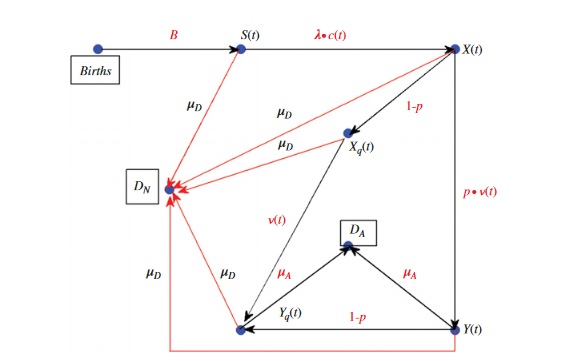

In [2]:
from IPython.display import Image
Image(filename='SEIR schema of HIV transmission and AIDS seroconversion.png')  

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import scipy 
from scipy import stats
from scipy import optimize
from scipy import integrate
from scipy.optimize import curve_fit 

### Initial values         

To exercise the model, estimates of the parameters $B, \beta(t), c(t), p, \mu_{A}, \mu_{D}, v(t)$ are required along with knowledge of the ***initial populations***. The initial values also provide us with the means to estimate some of the parameters directly.    

The book takes data based on the *greater Boston area* in 2005-2010. Reports by Renski et al. and *Centres for Disease Control* are used for the records on the *number of Births, deaths, domestic immigration (emigration), international immigration(emigartion),initial population of susceptibles (population size), number of $HIV^{+}$ and people with $AIDS$*. Following rather straightforward arithmetics, some of the initial estimates were obtained. I present the summary of the results in *Table 1*. Calculations are placed in the *Appendix* for their simplicity.      

*Table 1* ***Initial values for the various SEIR populations as a function of the proportion infectious $p$***     

| $S(t_{0})$| $X(t_{0})$| $X_{q}(t_{0})$ | $Y(t_{0})$| $Y_{q}(t_{0})$ | $B$ | $\mu_{D}$ |            
| :--- | :---: | :---: | :---: | :---: | :---: | ---: |           
| $1,975,155$| $6214p$| $6,214(1-p)$ | $3,709p$| $3,709(1-p)$ | $160, 398$ *people per year* | $0.0783$ |   

### Estimating $\beta$$(t)$ -  the probability of HIV transmission at time $t$           

$\lambda$$(t)$  $=$ $\beta$$(t)$$\frac{I(t)}{N(t)}$: the probability of HIV transmission per contact at time $t$ 

The transmission parameter $\beta$ is pretty much dependent on the type of interaction between the carrier of HIV and the exposed individual. In sex, the probability of transmission from a man to a woman $-\beta_{MF}-$ is $0.001$, while from a woman to a man $-\beta_{FM}-$ $0.000025$, the highest probability of transmission is in a male-to-male interaction, $-\beta_{MM}-$ $0.1$. Therefore, estimated $\beta$ is highly dependent on the composition pattern of a given population. Petersen et al. provided data on the transmission probabilities as a function of ***contact*** (with the $HIV^{+}$) and ***time***(days). This data will be used in our model for the probability of transmission.

In [2]:
hiv_betas = pd.read_csv("peterson hiv probabilities.csv")
hiv_betas['time_years'] = hiv_betas['time']/365.25 #from days to years
hiv_betas.head()

,beta_hat_t,time,time_years
0,0.63,40,0.109514
1,0.58,60,0.164271
2,0.50,80,0.219028
3,0.43,100,0.273785
4,0.36,120,0.328542


Transmission probability as a function of contact and time(years) is an exponential:    

$$
\beta(t,c) = c_{1}e^{-c_{2}(t-t_{1})} + c_{3}
$$

In the book, the parameters $c = (c_{1}, c_{2}, c_{3})$ were estimated in MATLAB with a non-linear regression fit for $t_{1}$ $= 40$ days or $0.1095$ year. The  estimates for $c$ are  $(0.5745, 2.9466, 0.0708)$. In addition to replicating parameters estimation with a regression fit, I will also show alternative numerical approach to estimate $c$ with a gradient descent. 

Estimating **c** with a non-linear regression fit yields estimates close to the author's:

In [3]:
betas_hat = hiv_betas['beta_hat_t'].values
t = hiv_betas['time_years'].values 

def model(t, c1, c2, c3): 
    "t1 = 0.1095"
    return c1*np.exp(-c2*(t-0.1095)) + c3  

popt, pcov = curve_fit(model, t, betas_hat) 
print(f"Estimated c1, c2 and c3 are {np.round(popt,4)}")

Estimated c1, c2 and c3 are [0.5756 2.9362 0.0696]


We can replicate the results of the regression fit numerically by showing at which values of $c$ the cost function $E(c)$ is minimized.   

$$ 
E(c) = \sum\limits_{j-1}^{N}(c_{1}e^{-c_{2}(t-t_{1})} + c_{3} - \hat{\beta}(t_{j})^{2}  
$$ 

Gradient descent finds the local or global optimal points where $E[c]$ is minimized by solving for vector $c$ the following set of equations: 
. 
$$
\triangledown E[c] = [\frac{\partial{E}}{\partial{c_{1}}}, \frac{\partial{E}}{\partial{c_{2}}},
\frac{\partial{E}}{\partial{c_{3}}}] = 0
$$

In [4]:
%%time

#partial derivatives if E(c) w.r.t c1,c2 and c3
def grad(t,betas_hat, c1,c2,c3):  
        dc1 = 2*np.sum((c1*np.exp(-c2*(t-t[0])) + c3 - betas_hat)* np.exp(-c2*(t-t[0])))
        dc2 = 2*np.sum((c1*np.exp(-c2*(t-t[0])) + c3 - betas_hat) *c1*np.exp(-c2*(t-t[0])) * (t[0]-t))
        dc3 = 2*np.sum((c1*np.exp(-c2*(t-t[0])) + c3 - betas_hat))
        return np.array([dc1,dc2,dc3])

#parameters
learning_rate= 0.01 # smaller learning rate yields a slower gradient descent, 
                    # but here we can't be faster, because with  greater learning rate
                    # our gradient will not converge
precision = 0.0001
previous_step_size = 1 
max_iters = 100000
iters = 0 

# starting point
C = np.array([-8,13,21]) # starting from here just to show the flexibility of the algorithm
                         # over a range of values
                         # normally, I would start from somewhere like C = np.array([1,1,1])

#Inputs of the cost function
betas_hat = hiv_betas['beta_hat_t'].values
t = hiv_betas['time_years'].values

while previous_step_size > precision and iters < max_iters: 
    C_prev = C
    C = C-learning_rate*grad(t, betas_hat, C[0], C[1], C[2])
    previous_step_size = abs((C-C_prev).any())
    iters = iters+1   
    
print(f"E[c] hits a local minimum when c1, c2 and c3 are {np.round(C,4)}") 

E[c] hits a local minimum when c1, c2 and c3 are [0.5756 2.9362 0.0696]
CPU times: user 5.34 s, sys: 0 ns, total: 5.34 s
Wall time: 5.34 s


As shown, given a sufficiently small learning rate, enough iterations and a reasonable initial point, the gradient descent arrived at values that are  identical to those of a regression fit. However, such drawbacks of the algorithm as sensitivity to the parameters of choice and computational time have to be taken into account. Remarkably, in our case the gradient only coverges to a local minimum, i.e. while we are comfortable within a good range of $c$, we still can't choose *any* initial values. $E[c]$, however, tends to be convex in regions of modest, unextreme, intuitively plausible values of $c$, which creates an advantageous setting for the application of the gradient descent. Below I've plotted $E[c]$ in 3D as a function of $c_{2}$ and $c_{3}$, treating $c_{1}$ as given. 

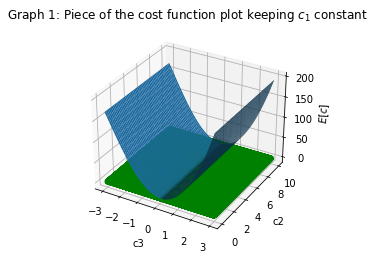

In [5]:
betas_hat = hiv_betas['beta_hat_t'].values
t = hiv_betas['time_years'].values 

c1 = 0.5756
c2_vals = np.arange(0,10, 0.01)
c3_vals = np.arange(-3,3,0.01) 

def cost(c2,c3):
    return np.sum((c1*np.exp(-c2*(t-t[0])) + c3 - betas_hat)**2)         
Z = np.array([cost(c2,c3) for c2,c3 in zip(c2_vals, c3_vals)]) 

c2_vals, c3_vals = np.meshgrid(c2_vals, c3_vals) 
Z=np.expand_dims(Z,axis=0)

zmin = np.min(Z)

ax = plt.axes(projection ='3d')
ax.plot_surface(c3_vals, c2_vals, Z.T)
ax.scatter(c3_vals, c2_vals,zmin, color = "g")
ax.set_xlabel('c3')
ax.set_ylabel('c2')
ax.set_zlabel('$E[c]$')
ax.set_title('Graph 1: Piece of the cost function plot keeping $c_{1}$ constant')
plt.show()

If we "zoom" and plot $E[c]$ over values of $c_{2}$ and $c_{3}$ in ranges that are close to the estimated points we can clearly see that the function hits a minimum at $c_{3} = 0.0696 \simeq 0.07$. A similar graph, but keeping $c_{3}$ constant is shown in the Appendix.

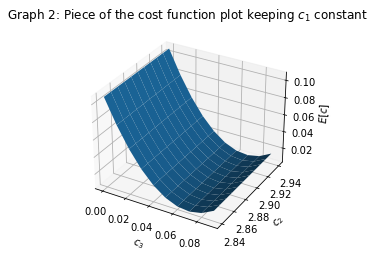

In [6]:
c1 = 0.5756
c2_vals = np.arange(2.84,2.94, 0.01)
c3_vals = np.arange(0,0.1,0.01) 

def cost(c2,c3):
    return np.sum((c1*np.exp(-c2*(t-t[0])) + c3 - betas_hat)**2)         
Z = np.array([cost(c2,c3) for c2,c3 in zip(c2_vals, c3_vals)]) 

c2_vals, c3_vals = np.meshgrid(c2_vals, c3_vals) 
Z=np.expand_dims(Z,axis=0)
ax = plt.axes(projection ='3d')
ax.plot_surface(c3_vals, c2_vals, Z.T)
ax.set_xlabel('$c_{3}$')
ax.set_ylabel('$c_{2}$')
ax.set_zlabel('$E[c]$')
ax.set_title('Graph 2: Piece of the cost function plot keeping $c_{1}$ constant')
plt.show()

In [7]:
def error(t, betas_hat):
    n = t.size 
    C_est  = np.tile(C, (1,n)) 
    C_est = C
    c1_est = C_est[0]
    c2_est = C_est[1]
    c3_est = C_est[2] 
    loss = np.sum((c1_est*np.exp(-c2_est*(t-t[0])) + c3_est - betas_hat)**2)
    error = np.sqrt((loss)/n)
    return error 

print(f"Root mean square error is {error(t, betas_hat):.{4}f}")

Root mean square error is 0.0146


Our estimated mean square error is close, but slightly smaller than the one obtained in the book: $0.0151$.

Plotting $\beta$ at estimated **c**

<font size="1.5">Note: *xlabel*, *ylabel* options are available in Python 3.8. Updates may be needed for older versions. On Nuvolos it runs.</font> 

<AxesSubplot:title={'center':'Graph 3: Petersen data'}, xlabel='time, years', ylabel='HIV transmission'>

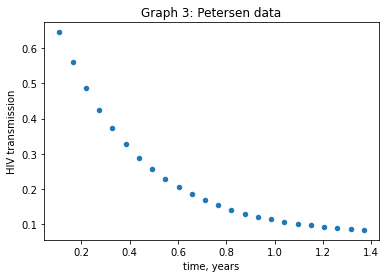

In [8]:
a = model(t,0.5756, 2.9362, 0.0696)
betas = pd.DataFrame({'x':t, 'y':a})
betas.plot('x', 'y', kind='scatter', xlabel = 'time, years', ylabel = 'HIV transmission',
           title = 'Graph 3: Petersen data')

Once $\hat{\beta}$ is found, the probability of HIV transmission per contact at time: $\lambda$$(t)$  $=$ $\beta$$(t; c)*$$\frac{I(t)}{N(t)} = \beta$$*(t; c)\frac{X(t) + Y(t)}{N(t)+X(t) + Y(t)} $ can be computed.

### Seroconversion rate and Incubation period      

Seroconversion refers to the process of transitioning from seronegative ($HIV^{+}$, but having no detectable antibodies[<sup>4</sup>](#fn4). Hence, the patient tests as negative while being infected and infectious) to seropositive ($HIV^{+}$ and having detectable antibodies, thus, the patient gets a true test result)[<sup>5</sup>](#fn5).  

The chapter uses literature estimates by Bacchetti and Moss. They estimated the probability of developing $AIDS$ once a person is $HIV^{+}$ as a function of time (years) $- hazard function$.

In [9]:
aids_probs = pd.read_csv("AIDS probs.csv") 
aids_probs.head()

,time_yr,haz_est
0,0,0.000
1,1,0.002
2,2,0.007
3,3,0.022
4,4,0.043


#### Some definitions       

$F(t)$: cumulative density function (cdf) of the seroconversion process    

$Haz(t):= \frac{F^\prime(t)}{1-F(t)} = \frac{f(t)}{1-F(t)}$, where $f(t)$ is the probability density function *(pdf)* of the seroconversion process   $*$ 

From $*$, it follows that $F(t) = 1 - e^{\int Haz(t)}$   $**$

The general objective here is to fit a mathematical model $F(t)$ to the estimated $\hat{F}(t)$ (*Costa*, 55).   

The capacity to model seroconversion time is the distinctive feature of the *SEIR* setting as opposed to other epidemic models, therefore I am going to give a closer look at $F(t)$.  As seen in $**$, to do that we first need to expole the integral of *hazard function* over the available time period.

#### Hazard function and estimated *cdf* of the seroconversion times     

<font size="1.5">In the book, no discussion on the integral of the hazard curve is held. I, however, decided to include it here as an exercise. Not only is it relevant to our class contents, but also this deviation from the book structure fits the context of my estimation approach that significantly diverges from the methods used in the book.</font>

Recollect that,  

$$    
Haz(t):= \frac{F^\prime(t)}{1-F(t)} = \frac{f(t)}{1-F(t)}  
$$

$$
F(t) = 1 - e^{\int Haz(t)}   
$$     

Plotting literature estimates of the hazard function:

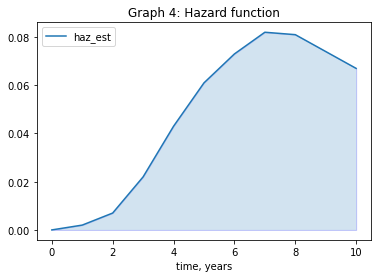

In [10]:
aids_probs.plot(x = "time_yr", y = "haz_est", xlabel = "time, years", title = "Graph 4: Hazard function")
plt.fill_between(aids_probs['time_yr'],aids_probs['haz_est'], edgecolor='b',alpha=0.2)

We can straighforwardly calculate the area under the *hazard function* for $t$ in $ [0, 10]$ using the trapezoidal rule.   
<font size="1.5">Note: $Area(trapezoid) = \frac{1}{2} (base_{1} + base_{2})  h$, where $h$ is the height.</font>   

The application of the trapezoidal rule to the *hazard function* is illustrated below.

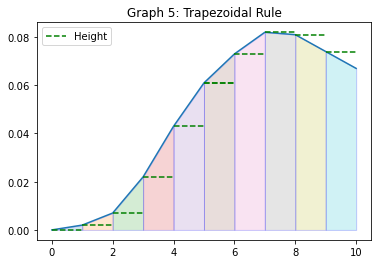

In [11]:
N = aids_probs.time_yr.size 

plt.plot(aids_probs.time_yr,aids_probs.haz_est)
plt.plot([aids_probs.time_yr[5],aids_probs.time_yr[6]],
         [aids_probs.haz_est[5],aids_probs.haz_est[5]], 'g--', label = "Height")


for i in range(N-1):     
    plt.fill_between([aids_probs.time_yr[i],aids_probs.time_yr[i+1]],
                     [aids_probs.haz_est[i],aids_probs.haz_est[i+1]], edgecolor='b',alpha=0.2)
    plt.plot([aids_probs.time_yr[i],aids_probs.time_yr[i+1]],
         [aids_probs.haz_est[i],aids_probs.haz_est[i]], 'g--')

plt.title('Graph 5: Trapezoidal Rule')
plt.legend()
plt.show()

In [12]:
results = [] 

for i in range(N-1):        
    a = aids_probs.time_yr[i] 
    b = aids_probs.time_yr[i+1]
    h = b-a 
    function = dict(zip(aids_probs.time_yr, aids_probs.haz_est))
    'Area of each trapezoid i'
    area = 1/2*(function[a] + function[b])*h 
    results.append(area) 
    cum_area = np.sum(results)
    'Cumulative area of trapezoids 1 to i: i, i-1,...,1'
    print(f"Cum. area of trapezoids up to {i+1} is {cum_area:.{5}f}")

Cum. area of trapezoids up to 1 is 0.00100
Cum. area of trapezoids up to 2 is 0.00550
Cum. area of trapezoids up to 3 is 0.02000
Cum. area of trapezoids up to 4 is 0.05250
Cum. area of trapezoids up to 5 is 0.10450
Cum. area of trapezoids up to 6 is 0.17150
Cum. area of trapezoids up to 7 is 0.24900
Cum. area of trapezoids up to 8 is 0.33050
Cum. area of trapezoids up to 9 is 0.40800
Cum. area of trapezoids up to 10 is 0.47850


We have computed the area of each of the 10 trapezoids as well as the cumulative sum of the areas. Now, let's see how our results compare to the performance of the in-built *scipy* function *cumtrapz*. 

In [13]:
#storing results all together 
integration = pd.DataFrame({'integration': np.array(results), 'cumulative': np.cumsum(results)})

#starting from 0. Naturally, at t=0, hazard function and hence its integral are zeros
initial_point = pd.DataFrame({'integration': [0], 'cumulative': [0]})
integration = pd.concat([initial_point, integration[:]]).reset_index(drop = True) 


#Double check with a cumulative integration using the composite trapezoidal rule from scipy.integrate.cumtrapz 
integration['cumulative_scipy'] = integrate.cumtrapz(aids_probs['haz_est'], x = aids_probs['time_yr'], initial=0) 

integration.head(11) 

,integration,cumulative,cumulative_scipy
0,0.0000,0.0000,0.0000
1,0.0010,0.0010,0.0010
2,0.0045,0.0055,0.0055
3,0.0145,0.0200,0.0200
4,0.0325,0.0525,0.0525
5,0.0520,0.1045,0.1045
6,0.0670,0.1715,0.1715
7,0.0775,0.2490,0.2490
8,0.0815,0.3305,0.3305
9,0.0775,0.4080,0.4080


Column *integration* stands for an individual area of each trapezoid, *cumulative* - our computed cumulative areas, *cumulative_scipy* - cumulative areas computed with *scipy*. The results are identical.  

Now, we can insert the estimated integrals into the seroconversion *cdf* $F(t) = 1 - e^{\int Haz(t)}$ and see how our estimated $\hat{F}(t)$ compares to the one in the book.

Estimated *cdf* of the seroconversion process in the book is     

$$
\Large
\hat{F}(t) = 1 - e^{\sum\limits_{\tau\leq\ t}\hat{Haz}(\tau)}
$$

In [14]:
aids_probs['cdf_est_integration'] = 1 - np.exp(-integration.cumulative)
aids_probs['cdf_est_book'] = 1 - np.exp(-np.cumsum(aids_probs.haz_est))
aids_probs['difference'] = np.round(abs(aids_probs['cdf_est_book'] - aids_probs['cdf_est_integration']),
                                    decimals = 3)
aids_probs.head(11)

,time_yr,haz_est,cdf_est_integration,cdf_est_book,difference
0,0,0.000,0.000000,0.000000,0.000
1,1,0.002,0.001000,0.001998,0.001
2,2,0.007,0.005485,0.008960,0.003
3,3,0.022,0.019801,0.030524,0.011
4,4,0.043,0.051146,0.071328,0.020
5,5,0.061,0.099225,0.126284,0.027
6,6,0.073,0.157600,0.187793,0.030
7,7,0.082,0.220420,0.251736,0.031
8,8,0.081,0.281436,0.309956,0.029
9,9,0.074,0.335021,0.359176,0.024


Column *cdf_est_integration* indicates $\hat{F}(t)$ obtained with estimating $\int Haz(t)$  using the trapezoidal rule. We can see that it is close to book $\hat{F}(t)$. 

Now, let's set back on the main goal of the chapter - estimating seroconversion rate $v(t)$ and, hence, the incubation period - $\frac{1}{v(t)}$. We have already indicated that the core objectice is to fit a mathematical model $F(t)$ to the estimated $\hat{F}(t)$. The book considers two underlying distributions: the Weibull and the generalized exponential.

#### Fitting $\hat{F}(t)$      

Assume the underlying distribution of seroconversion times is Weibull with parameters $a_{1}$ and $a_{2}$.    

$$  
F_{w}(t, a_{1}, a_{2}) = 1-e^{(-\frac{t}{a_{2}})^{a1}}
$$

$$
a_{1}, a_{2} > 0,    t > 0
$$ 

Let's take a brief look at what the Weibull cdf is like for different parameters $a_{1}$ and $a_{2}$.    

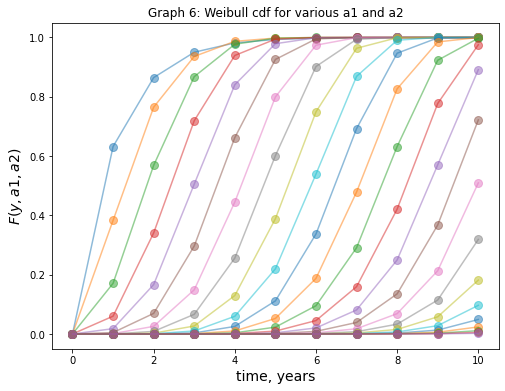

In [15]:
weibull = lambda t, a1, a2: 1-np.exp(-(t/a2)**a1) 
t = aids_probs['time_yr'].values

a1_values = np.linspace(1,15,25)
a2_values = np.linspace(1,15,25)

fig, ax = plt.subplots(figsize=(8, 6)) 
for a1,a2 in zip(a1_values, a2_values):
    distribution = [] 
    for t_i in t:
        distribution.append(weibull(t_i, a1, a2))    
    ax.plot(t,
        distribution,
        label=f'{a1,a2}',
        alpha=0.5,
        marker='o',
        markersize=8)    

#ax.legend(fontsize=14)
ax.set_xlabel('time, years', fontsize=14)
ax.set_ylabel('$F(y,a1,a2$)', fontsize=14)
ax.set_title("Graph 6: Weibull cdf for various a1 and a2")
plt.show()

The Weibull distribution is flexible and can take different shapes.

#### A few words on the Weibull distribution    

In the defined two-parameter Weibull distribution, $a_{1}$ is the shape parameter and $a_{2}$ is the scale parameter. $a_{2}$ is sometimes referred to as the *characteristic life* of the Weibull distribution due to its common use to model random lifetime of some system[<sup>6</sup>](#fn6). The Weibull *pdf* is, naturally, the derivative of its *cdf*:   
$$ 
f_{w}(t; a_{1}, a_{2}) = \frac{d}{dt}F_{a_{1}, a_{2}}(t) = \frac{a_{1}}{a_{2}}(\frac{t}{a_{2}})^{a_{1}-1}e^{-(\frac{t}{a_{2}})^{a_{1}}}
$$  

Maximum likelihood estimation (MLE) is the most commonly used way to estimate the Weibull distribution. Although MLE in the Weibull has to be paired with other numerical methods, because sometimes it can be hard to obtain a nice analytical solution for this distribution. As a reference point we start with an in-built *scipy* function that fits the Weibull. Since we are working with a two-parameter Weibull, our location parameter is set to zero.

In [16]:
t = np.array(aids_probs['time_yr'])
t = np.delete(t,[0]) # removing "0" from the range of t, because log is not defined for this point
params = stats.weibull_min.fit(t, floc=0) 
print(f"The shape, location, scale parameters are {np.round(params, 3)} respectively")

The shape, location, scale parameters are [1.984 0.    6.195] respectively


The shape parameter $a_{1}$ is estimated to be 1.984, the scale parameter $a_{2}$ is 6.195. Now, we proceed to replicate the estimation with MLE and Newton-Raphson algorithm.    
 
#### MLE with Newton-Raphson     

The approach here is to define an MLE problem and solve it with a Newton-Raphson algorithm (hereafter, the *NR*). Recollect that,  

$$
f_{w}(t; a_{1}, a_{2}) = \frac{a_{1}}{a_{2}}(\frac{t}{a_{2}})^{a_{1}-1}e^{-(\frac{t}{a_{2}})^{a_{1}}}
$$   

It follows that the log-likelihood $-l(a_{1}, a_{2})-$ has this form:    

$$    
l(a_{1}, a_{2}) = Nln(a_{1}) - Na_{1}ln(a_{2}) + (a_{1}-1) \sum\limits_{N} ln(t_{i})       
- \sum\limits_{N} (\frac{t_{i}}{a_{2}})^{a_{1}}   
$$  

The *NR* solves for $a_{1}$ and $a_{2}$ by the following rule:    

$$
a_{k+1} = a_{k} - H^{-1}(a_{k})G(a_{k})
$$   
where $G(a_{k}) = \frac{\partial l}{\partial a_{k}}$ and $H(a_{k}) = \frac{\partial^{2} l}{\partial a_{k}^{2}}$. The algorithm iterates until the tolerance level is met: $a_{k+1} - a_{k} < tol$. Computing the gradient vector and hessian matrix is critical for the *NR* to work, therefore I show in detail the derivations that were used in the algorithm (for a better readibility option I uploaded these derivations on paper in the final submission folder as well).   

First and second derivatives w.r.t. $a_{1}$:    

$\frac{\partial l}{\partial a_{1}} = \frac{N}{a_{1}} - Nln(a_{2}) + \sum ln(t_{i}) - \sum ln(\frac{t_{i}}{a_{2}})(\frac{t_{i}}{a_{2}})^{a_{1}}$    

$\frac{\partial^{2} l}{\partial a_{1}^{2}} = -\frac{N}{a_{1}^{2}} - \sum ln(\frac{t_{i}}{a_{2}})ln(\frac{t_{i}}{a_{2}})(\frac{t_{i}}{a_{2}})^{a_{1}} = -\frac{N}{a_{1}^{2}} - \sum [ln(\frac{t_{i}}{a_{2}})]^{2}(\frac{t_{i}}{a_{2}})^{a_{1}}$    

First and second derivatives w.r.t. $a_{2}$:    

$\frac{\partial l}{\partial a_{2}} = -Na_{1}\frac{1}{a_{2}} - \sum a_{1}(\frac{t_{i}}{a_{2}})^{a_{1}-1}*(-\frac{t_{i}}{a_{2}^{2}}) =   
-Na_{1}\frac{1}{a_{2}} + \frac{a_{1}}{a_{2}^{2}} \sum (\frac{t_{i}}{a_{2}})^{a_{1}-1} * t_{i} = 
-Na_{1}\frac{1}{a_{2}} + \frac{a_{1}}{a_{2}^{2}} \sum (\frac{t_{i}}{a_{2}})^{a_{1}} * \frac{a_{2}}{t_{i}}*t_{i} = -Na_{1}\frac{1}{a_{2}} + \frac{a_{1}}{a_{2}} \sum (\frac{t_{i}}{a_{2}})^{a_{1}}
$      

            

$\frac{\partial^{2} l}{\partial a_{2}^{2}} = \frac{Na_{1}}{a_{2}^{2}} + [-\frac{a_{1}}{a_{2}^{2}} \sum (\frac{t_{i}}{a_{2}})^{a_{1}} + \frac{a_{1}}{a_{2}} \sum a_{1} (\frac{t_{i}}{a_{2}})^{a_{1}-1} * (-\frac{t_{i}}{a_{2}^{2}})] = \frac{Na_{1}}{a_{2}^{2}} - \frac{a_{1}}{a_{2}^{2}} \sum (\frac{t_{i}}{a_{2}})^{a_{1}} - \frac{a_1^{2}}{a_{2}^{3}} \sum (\frac{t_{i}}{a_{2}})^{a_{1}-1} t_{i} = \frac{Na_{1}}{a_{2}^{2}} - \frac{a_{1}}{a_{2}^{2}} \sum (\frac{t_{i}}{a_{2}})^{a_{1}} - (\frac{a_{1}}{a_{2}})^{2} \sum (\frac{t_{i}}{a_{2}})^{a_{1}} $


In [17]:
t = np.array(aids_probs['time_yr'])
t = np.delete(t,[0]) # removing "0" from the range of t, because log is not defined for this point
N = len(t)

def gradient(a1,a2):    
    grad_a1 = N/a1 - N*np.log(a2) + np.sum(np.log(t)) - np.sum(np.power(t/a2,a1) * np.log(t/a2)) # correct
    grad_a2 = -N*a1/a2 + a1/a2*np.sum(np.power(t/a2,a1)) # correct
    return np.array([grad_a1, grad_a2]) 

def hessian(a1,a2): 
    hessian_a1 = -N/a1**2 - np.sum(np.power(t/a2,a1) * np.power(np.log(t/a2),2)) # correct
    hessian_a2 = N*a1/a2**2 -a1/a2**2*np.sum(np.power(t/a2,a1)) - (a1/a2)**2*np.sum(np.power(t/a2,a1)) # correct
    return np.array([hessian_a1, hessian_a2]) 

iters = 0     
a1_0, a2_0 = 3,8

while iters < 100:  
    a1 = a1_0 - gradient(a1_0,a2_0)[0]/hessian(a1_0, a2_0)[0]
    a2 = a2_0 - gradient(a1_0,a2_0)[1]/hessian(a1_0, a2_0)[1]
      
    print('Iteration-%d, a1= %0.6f, a2 = %0.6f, e1 = %0.6f, e2 = %0.6f' % (iters, a1,a2,a1-a1_0,a2-a2_0))
    if math.fabs(a1-a1_0) >0.001 or math.fabs(a2-a2_0) >0.001:
        a1_0,a2_0 = a1, a2
        iters = iters +1
    else: 
        break
print(a1,a2)
print(iters)

Iteration-0, a1= 1.328648, a2 = 5.598854, e1 = -1.671352, e2 = -2.401146
Iteration-1, a1= 1.749529, a2 = 5.749416, e1 = 0.420881, e2 = 0.150563
Iteration-2, a1= 1.888321, a2 = 6.016812, e1 = 0.138792, e2 = 0.267396
Iteration-3, a1= 1.951932, a2 = 6.131813, e1 = 0.063612, e2 = 0.115001
Iteration-4, a1= 1.973749, a2 = 6.175362, e1 = 0.021816, e2 = 0.043549
Iteration-5, a1= 1.980931, a2 = 6.189145, e1 = 0.007182, e2 = 0.013783
Iteration-6, a1= 1.983084, a2 = 6.193500, e1 = 0.002154, e2 = 0.004355
Iteration-7, a1= 1.983752, a2 = 6.194790, e1 = 0.000668, e2 = 0.001290
Iteration-8, a1= 1.983949, a2 = 6.195188, e1 = 0.000197, e2 = 0.000398
1.9839490261935802 6.195188312020462
8


For the given initial values the *NR* arrived at the same parameters as *scipy*'s in-built function in 8 iterations. The algorithm is fast, however, according to literature the *NR* is sensitive to the initial points and may not work well on small samples. Sensitivity can be confirmed with our data. Compared to the gradient descent, we have to choose starting values more carefully. With trial and error, I concluded that the *NR* works in the range $[1,8]$ for $a_{1}$ and $[1,9]$ for $a_{2}$. The 'worst' initial guess that still works is $(a_{1}, a_{2})$ at $(8,9)$, in this scenario the *NR* yields the correct estimates in 31 iterations. General literarure recommedation is to use estimates of a regression fit as starting values.   

Remarkably, *scipy* and the *NR* produced identical estimates for $(a_{1}, a_{2})$ at 1.984 and 6.195 respectively, but only the shape parameter estimate $-\hat a_{1}-$ coincides with the book estimates (1.984 vs 1.986 in the book). The scale parameter estimates $-\hat a_{2}-$ are different: 6.195 by *scipy* and *NR* vs. 13.571 in the book. The difference might come from the fact that non-linear regression fit (book) may work differently from MLE and *NR* when applied to the Weibull, which is generally a tricky distribution to estimate. In addition, the *NR* has been reported to perform worse on smaller samples. That said, we can at least confirm the validity of the *NR* in estimating the Weibull because it yields the same results as those by *scipy*. Also, it is more important that the shape parameter estimates coincide across all methods (*scipy, NR, and non-linear regression fir*), because it bears an interpretation. With $a_{1}$ > 1, the modelled system is subject to *aging*, in the sense that the older it gets the higher chances the system has to fail (*Fritz Schulz, 7*). In our context, it means that given $HIV^{+}$ status the probabily of changing status to *AIDS* increases with time.   

Let's us now visualize how our results compare to the book and data. 

In [18]:
t = np.array(aids_probs['time_yr']) 

def weibull_cdf(t, a1, a2): 
    cdf = 1 - np.exp(-np.power(t/a2,a1)) 
    return cdf 

def weibull_pdf(t,a1,a2): 
    pdf = a1/a2*np.power(t/a2, a1-1)*np.exp(-np.power(t/a2, a1))
    return pdf

#computing the hazard function with the Weibull
a1, a2 = 1.984, 6.195
weibull_haz = [weibull_pdf(i, a1, a2)/ (1-weibull_cdf(i, a1,a2)) for i in t] 

Let's take a look at the *cdf*-s

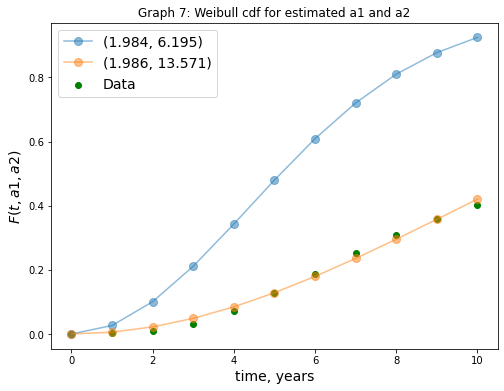

In [19]:
a1_values = [1.984, 1.986]
a2_values = [6.195, 13.571]

fig, ax = plt.subplots(figsize=(8, 6)) 
for a1,a2 in zip(a1_values, a2_values):
    distribution = [] 
    for t_i in t:
        distribution.append(weibull_cdf(t_i, a1, a2))      
    ax.plot(t,
        distribution,
        label=f'{a1,a2}',
        alpha=0.5,
        marker='o',
        markersize=8)  
    
ax.scatter(t, aids_probs['cdf_est_book'], label = 'Data', color = "green")
    

ax.legend(fontsize=14)
ax.set_xlabel('time, years', fontsize=14)
ax.set_ylabel('$F(t,a1,a2$)', fontsize=14)
ax.set_title("Graph 7: Weibull cdf for estimated a1 and a2")
plt.show()

*Graph 7* shows that pythonic estimations of the Weibull distributions do not fit the data particularly well because of the scale parameter $a_{2}$ that is twice as small as it was expected. Our estimations do not recommend the Weibull distribution to model seroconversion times on smaller samples.    

The second distribution *Costa* considers and in fact prefers to the Weibull is the generalized exponential. I am going to only show that *scipy optimize* confirms *Costa's* estimates:

In [20]:
def generalized_exp(t, b1,b2): 
    return (1-np.exp(-t/b2))**b1

popt, pcov = curve_fit(generalized_exp, t,aids_probs['cdf_est_book']) 
print(f"Estimated b1, b2 are {np.round(popt,4)}")

Estimated b1, b2 are [2.8478 7.5237]


<ipython-input-20-c68ba28c8e07>:2: RuntimeWarning: divide by zero encountered in power
  return (1-np.exp(-t/b2))**b1


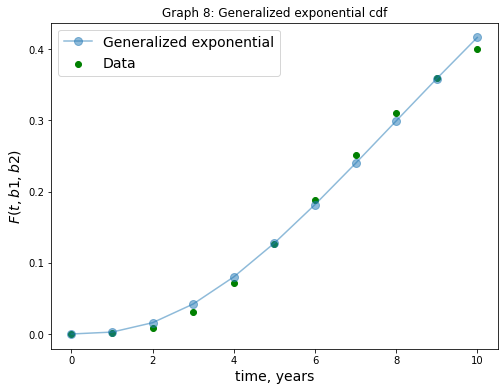

In [21]:
b1 = 2.8478 
b2 = 7.5237

fig, ax = plt.subplots(figsize=(8, 6))      
ax.plot(t,
   generalized_exp(t, b1, b2),
   label='Generalized exponential',
    alpha=0.5,
    marker='o',
    markersize=8)  
    
ax.scatter(t, aids_probs['cdf_est_book'], label = 'Data', color = "green")
    

ax.legend(fontsize=14)
ax.set_xlabel('time, years', fontsize=14)
ax.set_ylabel('$F(t,b1,b2$)', fontsize=14)
ax.set_title("Graph 8: Generalized exponential cdf")
plt.show()

The generalized exponential should be used to model the seroconversion rate:    

$$
v(t;b) = Haz_{G}(t;b) = \frac{f_{G}(t;b)}{1-F_{G}(t;b)}   
$$ 

$$
f_{G}(t;b) = \frac{b_{1}}{b_{2}} exp(-\frac{t}{b_{2}}) (1- exp(-\frac{t}{b_{2}})^{b_{1}-1}
$$ 

$$
b = [b_{1}, b_{2}] = [2.8478, 7.5237]
$$ 

The remaining parameters, $p$ (the proportion of people not quarantined) and $c$ number of contacts at time $t$ are varied over a range of plausible values. $p = \{1, 0.8, 0.5\}$ and $c$ is considered as a construction to examine the model behaviour, no estimations were carried out.

### Conclusion      

I've replicated the core results of a case study and estimated the parameters of a *SEIR* model, namely HIV transmission and seroconversion rate parameters. Numerical methods such as the gradient descent and Newton-Raphson algorithm were used alongside conventional econometric tools (regression fit). The project showed that algorithms are able to produce correct results with a high degree of precision. Solving a problem numerically requires a more careful exploration of the function in question, which leads to a deeper scientific effort. Above all, numerical methods can be the preferred solution if one is dealing with complicated functions. All results were visualized. I also showed that with the benefits that algorithms bring, they have some costs too. In this regard, longer computational time as well the need of a thorough analysis of the problem should be expected in order to design a properly working algorithm.

### Footnotes       
**1**. <span id="fn1"> For more detailed description and  addtional examples, see Costa, *Applied Mathematics for the Analysis of Biomedical data*, pp. 47-49     
    
**2**. <span id="fn2"> Costa, *Figure 3.1*, 48     

**3**. <span id="fn3"> Costa, *Figure 3.3*, 51
    
**4**. <span id="fn4"> Antibodies are proteins immune system produces when the body is invaded by what is recognized as aliens/threats, e.g. bacteria, viruses.     
    
**5**. <span id="fn5"> Costa, 55    
    
**6**. <span id="fn6"> *Inference for the Weibull Distribution*, Lecture notes by Fritz Scholz, Stat498B Industrial Statistics 2008

### Literature used      
*Applied Mathematics for the Analysis of Biomedical data. Models,methods and MATLAB*, Peter J. Costa, 2017  


*Inference for the Weibull Distribution*, Lecture notes by Fritz Scholz, Stat498B Industrial Statistics 2008  

*Effects of differend parametric estimates of seroconversion time on analysis of progression to AIDS among Italian HIV-positive haemophiliacs*, Flavia Chiarotti, Massimo Palombi, Nicola Schinaia, Alessandro Ghirardini, Luca Prospero, 1992   


### Appendix          

Relying on records by Renski et al., direct estimates of $B$ and $\mu_{D}$ can be obtained.      
$"Births" per year (B)$ should be taken in a broader sense and stands for all the new people who come *into* the Boston area. This number is constituted of the number of babies born and immigrants (domestic and international).   

$$
"Births" per year = B = \frac{\#births + domestic immigration + international immigation}{\# years}
$$    

$\mu_{D}$: rate at which people are removed from the population due to non-AIDS causes.     

$$
\mu_{D} = \frac{\#deaths + domestic emigration + international emigration}{Population}
$$

In [22]:
data_Renski = {'Region': ['Greater Boston area'], 
       'Period': ['2005 - 2010'], 
               'Total population': [1975155],
       'Number of births': [122374], # babies born
       'Domestic immigration': [526510], 
       'International immigration': [153105],
               'Number of deaths': [71114],
              'Domestic emigration': [547465], 
              'International emigration':[154198]}
initial_pop = pd.DataFrame(data_Renski) 

initial_pop['B'] = (initial_pop['Number of births'] + 
                   initial_pop['Domestic immigration'] + 
                   initial_pop['International immigration'])/5 

initial_pop['non-AIDS depletion rate'] = (initial_pop['Number of deaths'] + 
                   initial_pop['Domestic emigration'] + 
                   initial_pop['International emigration'])/initial_pop['Total population']/5 


initial_pop
initial_pop.head()

,Region,Period,Total population,Number of births,Domestic immigration,International immigration,Number of deaths,Domestic emigration,International emigration,B,non-AIDS depletion rate
0,Greater Boston area,2005 - 2010,1975155,122374,526510,153105,71114,547465,154198,160397.8,0.07825


$Pop_{2005} = 1,945,942$    
$Pop_{2010} = 1,975,155$     
The *Centers for Disease Control* provide records on the number of $HIV_{+}$ ($H_{0}$) and people with $AIDS$ ($A_{0}$) per $100,000$ people.    
$H_{0} = 314,6$    
$A_{0} = 187.8$    
Take $t_{0}$ to be 2010. This information leads to the estimates of the initial populations.    
$S(t_{0}) = 1,975,155$     
$X(t_{0})$:= initial infectious ($HIV^{+}$) population. People with $HIV^{+}$ in 2010 are $\frac{1,975,155}{100,000}*314.6 = 6213.8$. A portion $p$ of these people are **not** "quarantined" (e.g. they do not take antiretroviral therapy). Hence, $X(t_{0}) = 6214p$ and the "quarantined" $HIV^{+}$ people (are not considered as vectors of the infection spread) are then $X_{q}(t_{0}) = 6214(1-p)$       
AIDS population = $\frac{1,975,155}{100,000}*187.8 = 3709.3$. Infectious initial AIDS population = $Y(t_{0}) = 3709p$, non-infectious AIDS people = $Y_{q}(t_{0}) = 3709(1-p)$. These results are shown in *Table 1*.


Plotting $E[c]$ treating $c_{3}$ constant. Optimal value of $c_{2}$ can be observed.

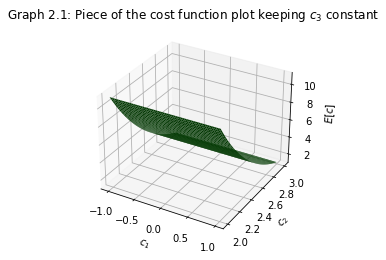

In [23]:
betas_hat = hiv_betas['beta_hat_t'].values
t = hiv_betas['time_years'].values
c3 = 0.0696
c1_vals = np.arange(-1,1, 0.001)
c2_vals = np.arange(2,3, 0.001) 

def cost(c1,c2):
    return np.sum((c1*np.exp(-c2*(t-t[0])) + c3 - betas_hat)**2)         
Z = np.array([cost(c1,c2) for c1,c2 in zip(c1_vals, c2_vals)]) 

c1_vals, c2_vals = np.meshgrid(c1_vals, c2_vals) 
Z=np.expand_dims(Z,axis=0)
ax = plt.axes(projection ='3d')
ax.plot_surface(c1_vals, c2_vals, Z.T, color = 'green')
ax.set_xlabel('$c_{1}$')
ax.set_ylabel('$c_{2}$')
ax.set_zlabel('$E[c]$')
ax.set_title('Graph 2.1: Piece of the cost function plot keeping $c_{3}$ constant')
plt.show()

<font size="1.5">Note: I needed to install the *sympy* package. For the notebook to run in Nuvolos, it should be restarted after installation.</font> 

In [16]:
#conda install --freeze-installed sympy
#conda install --freeze-installed plotly

In [24]:
import sympy
import plotly